# Regresión logística sobre una variable 

Bibliotecas y funciones auxiliares

In [249]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
def class_count(y_train):
    class_counts = y_train.value_counts()
    # Create a bar plot
    plt.bar(class_counts.index, class_counts.values, color=['red', 'green'])
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution in y_train')
    plt.xticks([0, 1], ['0', '1'])
    plt.show()
    return class_counts

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def plot_sigmoid(X, y, clf):
    # Create a range of balance values
    balance_values = np.linspace(X.min(), X.max(), 300)
    z = clf.intercept_[0] + clf.coef_[0][0] * balance_values
    sigmoid_values = sigmoid(z)

    # Plot the sigmoid function
    plt.figure(figsize=(10, 5))
    plt.plot(balance_values, sigmoid_values, label='Sigmoid Function')
    plt.scatter(X[y == 0], y[y == 0], c='blue', marker='o', alpha=0.5, label='Class 0')
    plt.scatter(X[y == 1], y[y == 1], c='red', marker='x', alpha=0.5, label='Class 1')

    plt.xlabel('Balance')
    plt.ylabel('Probability of Default')
    plt.title('Sigmoid Function for Logistic Regression Classifier')
    plt.legend()
    plt.show()

In [250]:
df = pd.read_csv('../../datasets/Default.csv')
df['default'] = df['default'].map({'No': 0, 'Yes': 1})

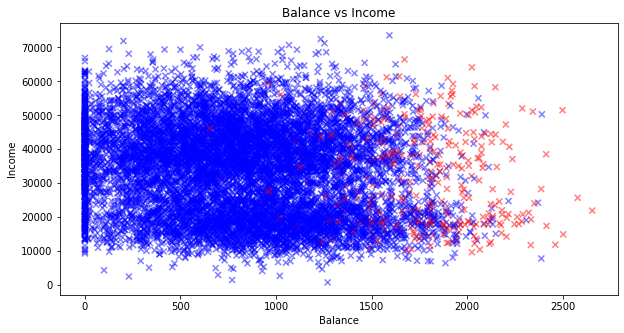

In [251]:
plt.figure(figsize=(10, 5))
plt.scatter(df['balance'],
            df['income'], c=df['default'].map({0: 'blue', 1: 'red'}), 
            marker='x', alpha=0.5)
plt.xlabel('Balance')
plt.ylabel('Income')
plt.title('Balance vs Income')
plt.show()

Al parecer la variable que mejor determina como clasificar es "Balance"

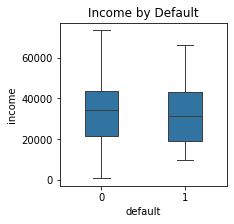

In [252]:
# Crear datos de ejemplo
# Crear el diagrama
plt.figure(figsize=(3, 3))
sns.boxplot(x='default', y='income', data=df, width=0.4, showfliers=False)  # Diagrama de cajas
#sns.stripplot(x='default', y='income', data=df, color='red', alpha=0.7, jitter=True, dodge=True)  # Puntos
# Ajustar detalles del gráfico
plt.title("Income by Default")
plt.show()


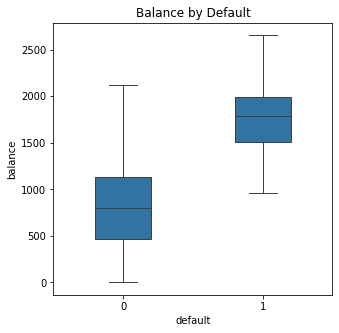

In [253]:
plt.figure(figsize=(5, 5))
sns.boxplot(x='default', y='balance', data=df, width=0.4, showfliers=False)  # Diagrama de cajas
#sns.stripplot(x='default', y='income', data=df, color='red', alpha=0.7, jitter=True, dodge=True)  # Puntos
# Ajustar detalles del gráfico
plt.title("Balance by Default")
plt.show()

Clasificamos solo por balance...

In [254]:
#X = df[['balance', 'income', 'student']]
X = df[['balance']]
y = df['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [255]:
clf = LogisticRegression(solver='liblinear')
clf.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      2906
           1       0.70      0.15      0.25        94

    accuracy                           0.97      3000
   macro avg       0.84      0.57      0.62      3000
weighted avg       0.96      0.97      0.96      3000



In [256]:
print(clf.coef_, clf.intercept_)

[[0.00421343]] [-8.52572399]


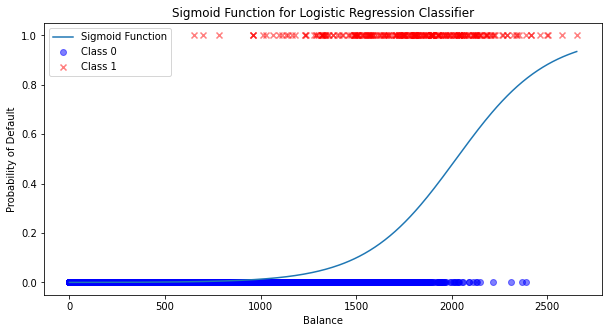

In [257]:
plot_sigmoid(X_train, y_train, clf)

Imaginemos un escenario donde lo mas importante es el recall, no quiero que un defaulteador reciba un beneficio determinado a costa de que buenos pagadores tampoco lo hagan (es un mal considerado menor). Necesito entonces mejorar el recall. ¿No esta desbalanceadas las clases?¿Será mejor si normalizo?

In [258]:
ss = StandardScaler()
ss.fit(X_train)
X_train_std = ss.transform(X_train)
X_test_std = ss.transform(X_test)
clf.fit(X_train_std, y_train)
print(classification_report(y_test, clf.predict(X_test_std)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2906
           1       0.73      0.26      0.38        94

    accuracy                           0.97      3000
   macro avg       0.85      0.63      0.68      3000
weighted avg       0.97      0.97      0.97      3000



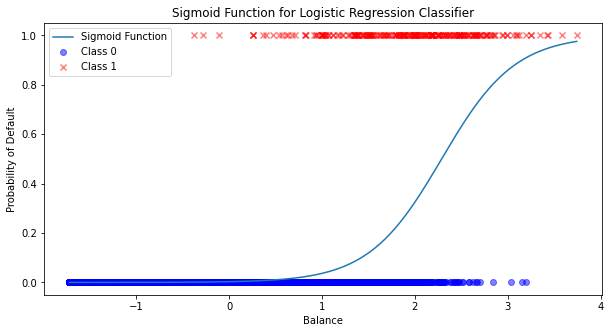

In [260]:
plot_sigmoid(X_train_std, y_train, clf)

La normalización ya ofreció mejores resultados.

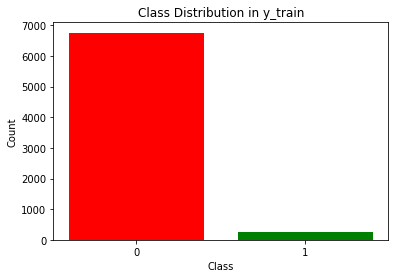

In [261]:
categorias = class_count(y_train)


Veamos el porcentaje

In [263]:
print(categorias[0], categorias[1],categorias[1]/categorias[0])

6761 239 0.03534980032539565


3% quiza algo se puede hacer...

In [264]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
X = df[['balance']]
y = df['default']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42)


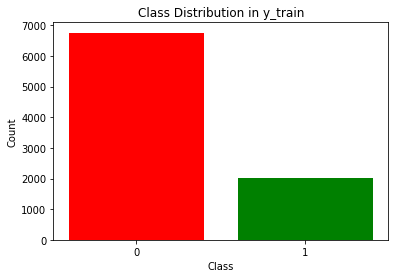

default
0    6761
1    2028
Name: count, dtype: int64

In [265]:

ros = RandomOverSampler(random_state=42, sampling_strategy=0.3)
X_train, y_train = ros.fit_resample(X_train, y_train)
class_count(y_train)

Ahora el conjunto entrenará con mayor cantidad de datos de la clase 1.

In [266]:
ss = StandardScaler()
ss.fit(X_train)
X_train_std = ss.transform(X_train)
X_test_std = ss.transform(X_test)
clf.fit(X_train_std, y_train)
print(classification_report(y_test, clf.predict(X_test_std)))


              precision    recall  f1-score   support

           0       0.99      0.94      0.96      2906
           1       0.27      0.67      0.39        94

    accuracy                           0.93      3000
   macro avg       0.63      0.81      0.68      3000
weighted avg       0.97      0.93      0.95      3000



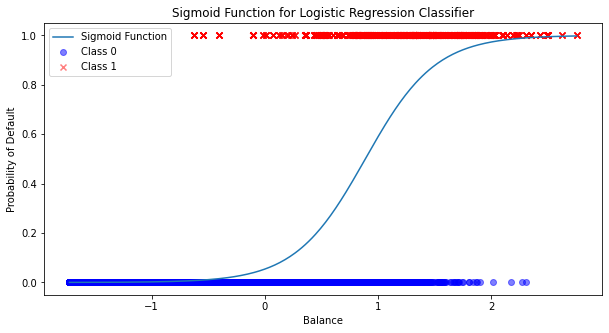

In [267]:
plot_sigmoid(X_train_std, y_train, clf)

Se observa un aumento del recall para la clase 1, es decir la clase de interes.

Probemos submuestreando la clase mayoritaria dado que el modelo es muy simple y con pocos datos debería ser suficiente.

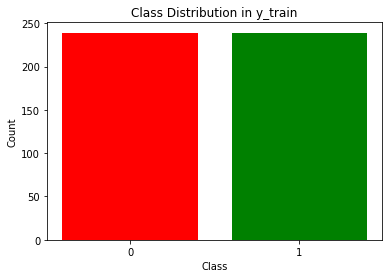

default
0    239
1    239
Name: count, dtype: int64

In [268]:
X = df[['balance']]
y = df['default']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42)
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)
# Count the occurrences of each class in y_train
class_count(y_train)

In [269]:
ss = StandardScaler()
ss.fit(X_train)
X_train_std = ss.transform(X_train)
X_test_std = ss.transform(X_test)
clf = LogisticRegression(solver='liblinear')
clf.fit(X_train_std, y_train)
print(classification_report(y_test, clf.predict(X_test_std)))

              precision    recall  f1-score   support

           0       1.00      0.85      0.92      2906
           1       0.16      0.88      0.27        94

    accuracy                           0.85      3000
   macro avg       0.58      0.87      0.59      3000
weighted avg       0.97      0.85      0.90      3000



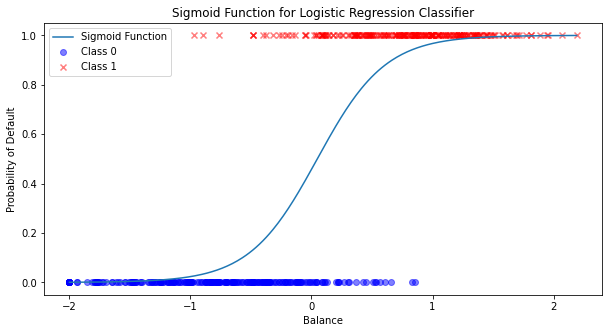

In [270]:
plot_sigmoid(X_train_std, y_train, clf)

¿Podemos mejorar el rendimiento modificando los hiperparametros?

#TODO probar con pesos en las clases

In [271]:
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(estimator=LogisticRegression(),
                  param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver':['lbfgs', 'liblinear']},
                  scoring='recall', cv=3)
gs.fit(X_train_std, y_train)
print(classification_report(y_test, clf.predict(X_test_std)))



              precision    recall  f1-score   support

           0       1.00      0.85      0.92      2906
           1       0.16      0.88      0.27        94

    accuracy                           0.85      3000
   macro avg       0.58      0.87      0.59      3000
weighted avg       0.97      0.85      0.90      3000



No, el modelo es muy simple...con todo alcanzamos un buen recall aunque el clasificador en terminos generales no sea tan bueno.